In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def initialize_centroids_kmeans_plus_plus(pixels, K):
    centroids = []
    # Randomly select the first centroid from the data points
    centroids.append(pixels[np.random.randint(pixels.shape[0])])

    # Select the remaining K-1 centroids
    for _ in range(1, K):
        distances = np.array([min([np.sqrt(np.sum((pixel - centroid) ** 2)) for centroid in centroids]) for pixel in pixels])
        probs = distances / np.sum(distances)
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()
       
        for j, p in enumerate(cumulative_probs):
            if r < p:
                centroids.append(pixels[j])
                break

    return np.array(centroids)

In [3]:
def compute_distance(pixel, centroid):
    return np.sqrt(np.sum((pixel - centroid) ** 2))

In [4]:
def assign_pixels_to_centroids(pixels, centroids):
    clusters = {}
    for i in range(len(centroids)):
        clusters[i] = []
   
    for pixel in pixels:
        distances = [compute_distance(pixel, centroid) for centroid in centroids]
        closest_index = np.argmin(distances)
        clusters[closest_index].append(pixel)
   
    return clusters

In [5]:
def recompute_centroids(clusters, K):
    centroids = np.zeros((K, 3))
    for idx in clusters:
        centroids[idx] = np.mean(clusters[idx], axis=0)
    return centroids

In [6]:
def kmeans(pixels, K, max_iters=100, tolerance=1e-4, visualize=False):
    centroids = initialize_centroids_kmeans_plus_plus(pixels, K)
    previous_centroids = centroids.copy()
    for iteration in range(max_iters):
        clusters = assign_pixels_to_centroids(pixels, centroids)
        centroids = recompute_centroids(clusters, K)
       
        # Calculate L2 norm to log it
        l2_norm = np.sqrt(np.sum((centroids - previous_centroids) ** 2))
        with open('L2_norm_log.txt', 'a') as log_file:
            log_file.write(f'Iteration {iteration}: L2 Norm = {l2_norm}\n')
       
        # Check convergence
        if np.all(np.abs(centroids - previous_centroids) < tolerance):
            break
       
        previous_centroids = centroids.copy()
       
        if visualize:
            quantized_image = create_quantized_image(pixels, clusters, centroids)
            display_image(quantized_image)
   
    return clusters, centroids

In [7]:
def create_quantized_image(pixels, clusters, centroids):
    quantized_pixels = np.zeros(pixels.shape)
    flat_pixels=pixels.reshape(-1,3)

    for idx, cluster in clusters.items():
        cluster=np.array(cluster)
        mask=np.isin(flat_pixels,cluster).all(axis=1)

        quantized_pixels[mask] = centroids[idx]
    return quantized_pixels.reshape(height, width, 3).astype(np.uint8)


In [8]:
def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [9]:
def evaluate_l2_norm(original_pixels, quantized_pixels):
    return np.sqrt(np.sum((original_pixels - quantized_pixels) ** 2))

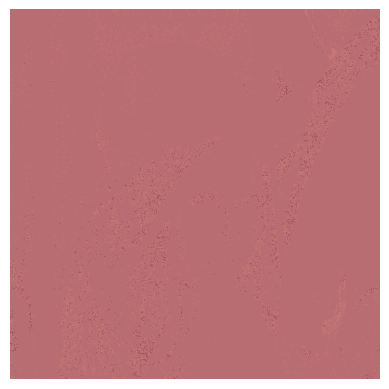

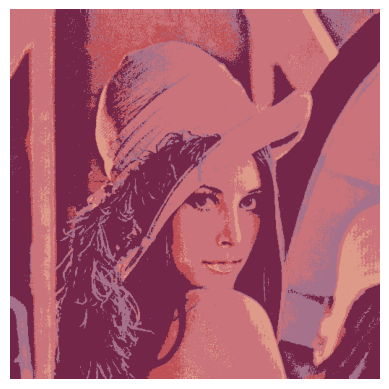

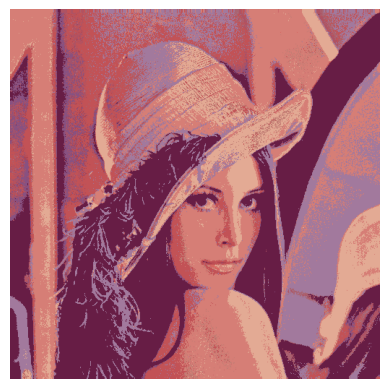

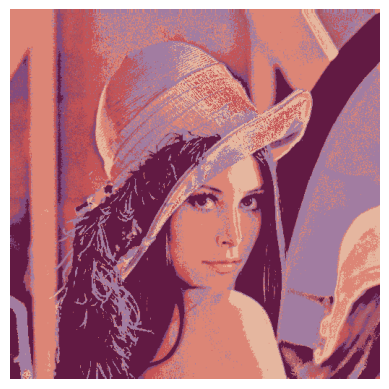

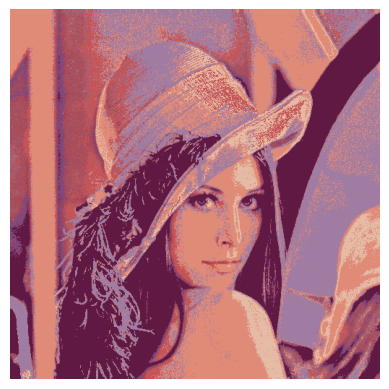

Total L2 norm for lena: 8236.858624499999


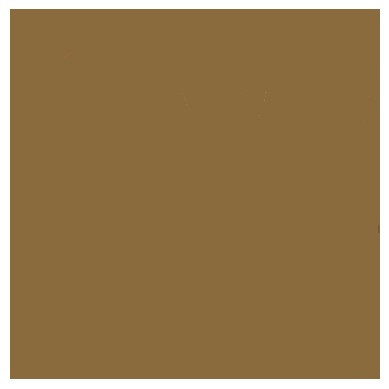

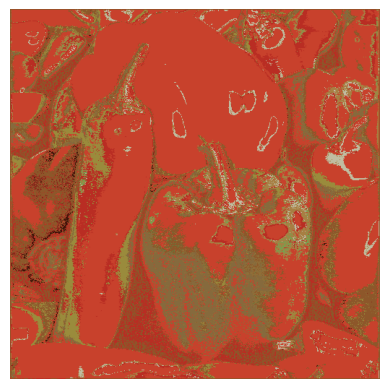

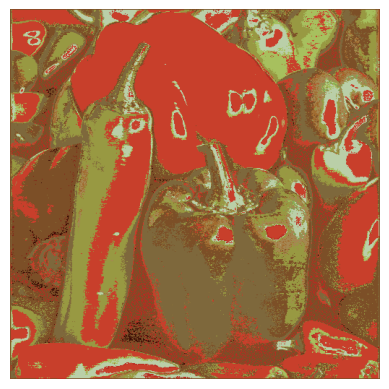

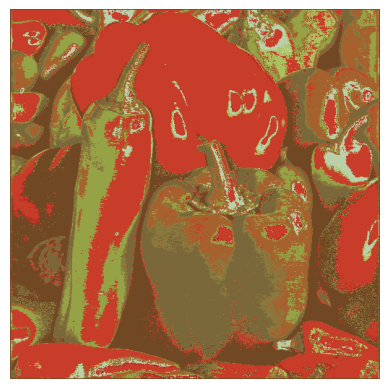

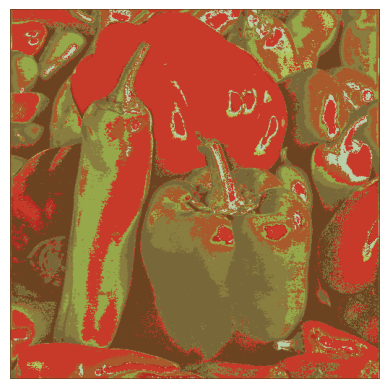

Total L2 norm for peppers: 8567.907737598485


In [10]:
if __name__ == "__main__":
    # Load images
    image_1 = cv2.imread('lena.png')
    image_2 = cv2.imread('peppers.tif')

    for image, name in zip([image_1, image_2], ["lena", "peppers"]):
        height, width, _ = image.shape
        pixels = image.reshape(-1, 3)

        # Perform K-means quantization
        K = 16
        clusters, centroids = kmeans(pixels, K,max_iters=5, visualize=True)

        # Reconstruct quantized image
        quantized_image = create_quantized_image(pixels, clusters, centroids)

        # Save the quantized image
        cv2.imwrite(f'{name}_quantized.png', quantized_image)

        # Evaluate total L2 norm
        l2_distance = evaluate_l2_norm(pixels, quantized_image.reshape(-1, 3))
        print(f'Total L2 norm for {name}: {l2_distance}')